# Análise da clusterização temporal

## Imports, definição de funções e carregamento dos dados

In [2]:
from b_limpar.limpador import Limpador
from b_vetorizar.vetorizador import Vetorizador
from d_clusterizar_por_tempo import clusterizador_temporal
from c_clusterizar_por_texto.clusterizador_textual import ClusterizadorTextual
from _common import util
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

def gerar_grafico_kde(resultado_kde):
    plt.plot(resultado_kde['eixo_x'], resultado_kde['eixo_y'])
    for m in resultado_kde['minimos_locais']:
        plt.plot(resultado_kde['eixo_x'][m],resultado_kde['eixo_y'][m],'go')

def converter_datas_para_segundos(datas_str):
    f = '%Y-%m-%d %H:%M:%S'
    datas = []
    for d in datas_str:
        datas.append(datetime.strptime(d, f))
    datas_as_seconds = np.array([(d-datas[0]).total_seconds() for d in datas])
    return datas_as_seconds

noticias_df = util.carregar_todas_as_noticias() 
Limpador().limpar_se_necessario(noticias_df)
Vetorizador().vetorizar(noticias_df)
ClusterizadorTextual().clusterizar(noticias_df)
clusterizador = clusterizador_temporal.ClusterizadorTemporal()


Carregando todas as notícias


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Edson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Baixando e carregando modelo SBERT
Vetorizando com SBERT


## Escolha do hiperparâmetro bandwidth

Como não se tem ideia do bandwidth adequado para o algoritmo, será usada uma fração da diferença entre a maior e a menor data. Será buscado na célula abaixo um denominador entre 1 e 100. Foram escolhidas algumas datas/horas de exemplo, que devem ser separadas razoavelmente em 6 ou 7 clusters, visto que algumas dessas datas têm intervalo pequeno entre si quando levado em conta o escopo geral das datas, devendo essas ser agrupadas juntas. 

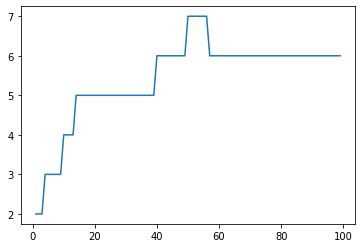

In [12]:
datas_as_seconds = converter_datas_para_segundos([
    "2022-05-18 19:08:15",
    "2022-05-18 20:25:36",
    "2022-05-18 21:50:33",
    "2022-05-19 03:17:08",
    "2022-05-19 16:16:13",
    "2022-05-21 07:00:00",
    "2022-05-23 07:00:00",
    "2022-05-27 13:17:04",
    "2022-05-27 22:18:00",])

num_minimos_locais_por_i = {}
for i in range(1, 100, 1):
    resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=i)
    num_minimos_locais_por_i.update({i: len(resultado_kde['minimos_locais'])})

plt.plot(list(num_minimos_locais_por_i.keys()), list(num_minimos_locais_por_i.values()))

Pelo gráfico, percebe-se que, a partir do valor 20 para o denominador, o número de mínimos locais já é razoável. Será escolhido então o valor médio de 60 para o denominador. Segue o resultado do KDE para esse valor. Os pontos verdes são os mínimos locais que delimitarão os clusters.

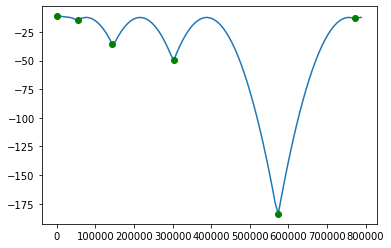

In [13]:
resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=60)
gerar_grafico_kde(resultado_kde)

Aplicando agora esse valor para outro conjunto de datas/horas, todas no mesmo dia. Esperam-se neste caso 3 clusters, visto que duas datas encontram-se muito próximas, com intervalo de apenas 10 minutos:

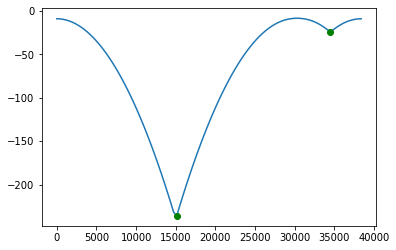

In [14]:
datas_as_seconds = converter_datas_para_segundos([
    '2022-09-17 07:20:25',
    '2022-09-17 15:40:30',
    '2022-09-17 15:50:55',
    '2022-09-17 18:00:20'])

resultado_kde = clusterizador.aplicar_kde(datas_as_seconds, denominador_bandwidth=60)
gerar_grafico_kde(resultado_kde)

Conforme visto, também nessa situação o denominador escolhido resultou no número esperado de clusters.

## Visualização dos clusters

A célula abaixo salva no arquivo resultado_clusterizacao_temporal.json (e também exibe no output) as notícias clusterizadas pelo texto e pelo tempo. 

In [15]:
assuntos = clusterizador.clusterizar(noticias_df, denominador_bandwidth=60)
for assunto in assuntos:
    for subcluster in assunto['subclusters']:
        subcluster['evento']['data_publ'] = subcluster['evento']['data_publ'].isoformat()
assuntos_as_json = json.dumps(assuntos, indent=4)
with open("resultado_clusterizacao_temporal.json", "w") as outfile:
    outfile.write(assuntos_as_json)
assuntos

[{'id': 0,
  'subclusters': [{'evento': {'id': 'https://g1.globo.com/sp/vale-do-paraiba-regiao/noticia/2022/10/05/policia-prende-homem-suspeito-de-gerenciar-o-trafico-de-drogas-em-taubate-sp.ghtml',
     'fonte': 'G1',
     'titulo': 'Polícia prende homem suspeito de gerenciar o tráfico de drogas em Taubaté, SP',
     'resumo': '<img src="https://s2.glbimg.com/xzz0HSBzeURS61W2ejlmAWweTsA=/i.s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/internal_photos/bs/2022/x/F/oyIdswQ0agO94h5U2ngA/policia-prende-homem-com-mandado-de-prisao-por-envolvimento-no-trafico-de-drogas-em-taubate-sp-2.jpg" /><br />   Agentes também localizaram drogas, anotações referente ao tráfico, celulares e notebooks na casa do criminoso. Polícia prende homem com mandado de prisão por envolvimento no tráfico de drogas em Taubaté\nDivulgação\nUm homem com mandado de prisão e acusado de ter envolvimento com a \'gerência do tráfico\' na região foi preso pela Polícia Militar nesta quarta-feira (5), em Taubaté (SP).\